## 1. Loading Dataset and Dependencies.

In [ ]:
# pip install lime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from lime.lime_tabular import LimeTabularExplainer


In [ ]:
# Load dataset
file_path = 'PhiUSIIL_Phishing_URL_Dataset.csv'
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

## 2. Data Preprocessing

### 2.1 Drop irrelevant Columns

In [ ]:
# Necessary categorical columns are already encoded
# Drop ['FILENAME', 'URL', 'DOMAIN', 'TLD', 'TITLE'] columns,
# as they are not needed for the model training, and causes issues with the model

df = df.select_dtypes(include=['number']).copy()

# Remove duplicate rows
df = df.drop_duplicates()
df.shape



(234987, 51)

### 2.2 Train-test Split

In [ ]:
# Split
X = df.iloc[:, :-1]  # All rows, all columns except the last one
y = df.iloc[:, -1]   # All rows, only the last column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

print("\nSample of X_train:\n")
print(X_train.head())

Training set shape: (187989, 50), (187989,)
Testing set shape: (46998, 50), (46998,)

Sample of X_train:

        URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
230273         25            18           0          100.000000   
33785          34            27           0          100.000000   
162124         52            44           0           25.635904   
6223           38            32           0           24.305067   
163654         31            24           0          100.000000   

        CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
230273              0.363636           0.009442     0.051582          2   
33785               1.000000           0.522907     0.060463          3   
162124              0.536585           0.005977     0.061033          2   
6223                0.791667           0.038420     0.027053          3   
163654              1.000000           0.522907     0.058380          3   

        NoOfSubDomain  HasObfuscation  .

### 2.3 Feature Scaling

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Shape after scaling: X_train: {X_train_scaled.shape}, X_test: {X_test_scaled.shape}")

print("\nSample of X_train_scaled:\n")
X_train_scaled.head()


Shape after scaling: X_train: (187989, 50), X_test: (46998, 50)

Sample of X_train_scaled:



,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
230273,-0.230912,-0.375163,-0.053122,0.740796,-2.224016,-0.995489,-0.395686,-1.268369,1.386192,-0.04536,...,-0.382312,-0.559023,-0.154577,-0.977470,-0.157598,0.055068,-0.066495,0.034904,-0.129627,0.148724
33785,-0.013278,0.607587,-0.053122,0.740796,0.712374,1.045659,0.442589,0.393380,-0.275250,-0.04536,...,2.615664,1.788836,-0.154577,1.023049,0.223245,-0.052557,-0.193547,-0.085771,-0.129627,0.011043
162124,0.421991,2.463891,-0.053122,-1.827482,-1.425972,-1.009264,0.496348,-1.268369,1.386192,-0.04536,...,-0.382312,-0.559023,-0.154577,-0.977470,-0.341453,-0.076473,-0.447652,-0.393493,-0.129627,-0.303657
6223,0.083449,1.153558,-0.053122,-1.873444,-0.248944,-0.880296,-2.710865,0.393380,3.047633,-0.04536,...,-0.382312,-0.559023,-0.154577,-0.977470,-0.341453,-0.076473,-0.447652,-0.393493,-0.129627,-0.316769
163654,-0.085822,0.280004,-0.053122,0.740796,0.712374,1.045659,0.245990,0.393380,-0.275250,-0.04536,...,2.615664,1.788836,-0.154577,1.023049,1.431435,0.043110,0.484067,2.357903,0.302759,1.492756


### Compare SMOTE, ADASYN, BorderlineSMOTE

In [ ]:
# Check original class distribution
print("Original class distribution in training set:")
print(y_train.value_counts())

# Apply SMOTE
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE:")
print(y_smote.value_counts())

# Apply ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_resample(X_train_scaled, y_train)
print("\nAfter ADASYN:")
print(y_adasyn.value_counts())

# Apply BorderlineSMOTE
X_bsmote, y_bsmote = BorderlineSMOTE(random_state=42, kind='borderline-1').fit_resample(X_train_scaled, y_train)
print("\nAfter BorderlineSMOTE:")
print(y_bsmote.value_counts())

Original class distribution in training set:
label
1    107880
0     80109
Name: count, dtype: int64

After SMOTE:
label
1    107880
0    107880
Name: count, dtype: int64

After ADASYN:
label
1    107880
0    107840
Name: count, dtype: int64

After BorderlineSMOTE:
label
1    107880
0    107880
Name: count, dtype: int64


### Apply SMOTE

In [ ]:
# Apply SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

print(f"Shape after SMOTE resampling: {X_train_resampled.shape}")
print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())

Shape after SMOTE resampling: (215760, 50)

Class distribution after SMOTE:
label
1    107880
0    107880
Name: count, dtype: int64


## 3. Feature Selection

In [ ]:
# Initialize SelectKBest
k = 25  # Change the number of features you want to select
selector = SelectKBest(score_func=f_classif, k=k)

# Fit on resampled training data
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Apply the same selection on test data
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[selector.get_support()].tolist()

print(f"Top {k} selected features:\n")
print(selected_features)

print("\nShape of selected training set:", X_train_selected.shape)
print("Shape of selected testing set:", X_test_selected.shape)


Top 25 selected features:

['URLSimilarityIndex', 'CharContinuationRate', 'URLCharProb', 'LetterRatioInURL', 'DegitRatioInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'HasDescription', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'Pay', 'HasCopyrightInfo', 'NoOfImage', 'NoOfJS', 'NoOfSelfRef', 'NoOfExternalRef']

Shape of selected training set: (215760, 25)
Shape of selected testing set: (46998, 25)


## 4. Model Training

In [ ]:
# Models dictionary to save best models
models = {}

### 4.1 Decision Tree Classifier with GridSearchCV

In [ ]:
# Decision Tree Classifier with GridSearchCV

# Define parameter grid
dt_params = {
    'max_depth': [5, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

# Fit model
dt.fit(X_train_selected, y_train_resampled)

# Save best model
models['Decision Tree'] = dt.best_estimator_

print("✅ Decision Tree training complete and model saved.")

✅ Decision Tree training complete and model saved.


### 4.2 Random Forest Classifier with GridSearchCV

In [ ]:
# Random Forest
rf_params = {'n_estimators': [100], 'max_depth': [10, 20]}

# GridSearchCV
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='f1', n_jobs=-1)

# Fit model
rf.fit(X_train_selected, y_train_resampled)

# Save best model
models['Random Forest'] = rf.best_estimator_

print("✅ Random Forest training complete and model saved.")

✅ Random Forest training complete and model saved.


### 4.3 Logistic Regression with GridSearchCV

In [ ]:
# Logistic Regression
lr_params = {'C': [0.1, 1, 10]}

# GridSearchCV
lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, scoring='f1', n_jobs=-1)

# Fit the model
lr.fit(X_train_selected, y_train_resampled)

# Save the best estimator
models['Logistic Regression'] = lr.best_estimator_

print("✅ Logistic Regression training complete and model saved.")

✅ Logistic Regression training complete and model saved.


### 4.4 KNN with GridSearchCV

In [ ]:
# Define KNN parameter grid
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Setup GridSearchCV
knn = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

# Fit model
knn.fit(X_train_selected, y_train_resampled)

# Save best model
models['KNN'] = knn.best_estimator_

print("✅ K-Nearest Neighbors training complete and model saved.")

✅ K-Nearest Neighbors training complete and model saved.


### 4.5 Gradient Boosting Classifier with GridSearchCV

In [ ]:
# Define parameter grid
gbc_params = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Initialize GridSearchCV
gbc = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gbc_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

# Fit model
gbc.fit(X_train_selected, y_train_resampled)

# Save best model
models['Gradient Boosting'] = gbc.best_estimator_

print("✅ Gradient Boosting training complete and model saved.")


✅ Gradient Boosting training complete and model saved.


### 4.6 Support Vector Machine (SVM) with GridSearchCV

In [ ]:
# Define parameter grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

# Fit model
svm.fit(X_train_selected, y_train_resampled)

# Save best model
models['SVM'] = svm.best_estimator_

print("✅ Support Vector Machine training complete and model saved.")


✅ Support Vector Machine training complete and model saved.


### 4.7 XGBoost with GridSearchCV

In [19]:
# Define parameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

# Initialize GridSearchCV
xgb = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    xgb_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

# Fit model
xgb.fit(X_train_selected, y_train_resampled)

# Save best model
models['XGBoost'] = xgb.best_estimator_

print("✅ XGBoost training complete and model saved.")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:15:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost training complete and model saved.


### 4.8 Stacking Classifier

In [20]:
# Define base learners (we can use simpler or diverse models)
base_learners = [
    ('decision_tree', models['Decision Tree']),
    ('knn', models['KNN']),
    ('svm', models['SVM'])
]

# Define meta-learner
meta_learner = LogisticRegression(random_state=42, max_iter=5000)

# Initialize Stacking Classifier
stacking = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True
)

# Fit stacking model
stacking.fit(X_train_selected, y_train_resampled)

# Save stacking model
models['Stacking'] = stacking

print("✅ Stacking Classifier training complete and model saved.")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Stacking Classifier training complete and model saved.


## 5. Evaluation


🔍 Model: Decision Tree
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 0.9999

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


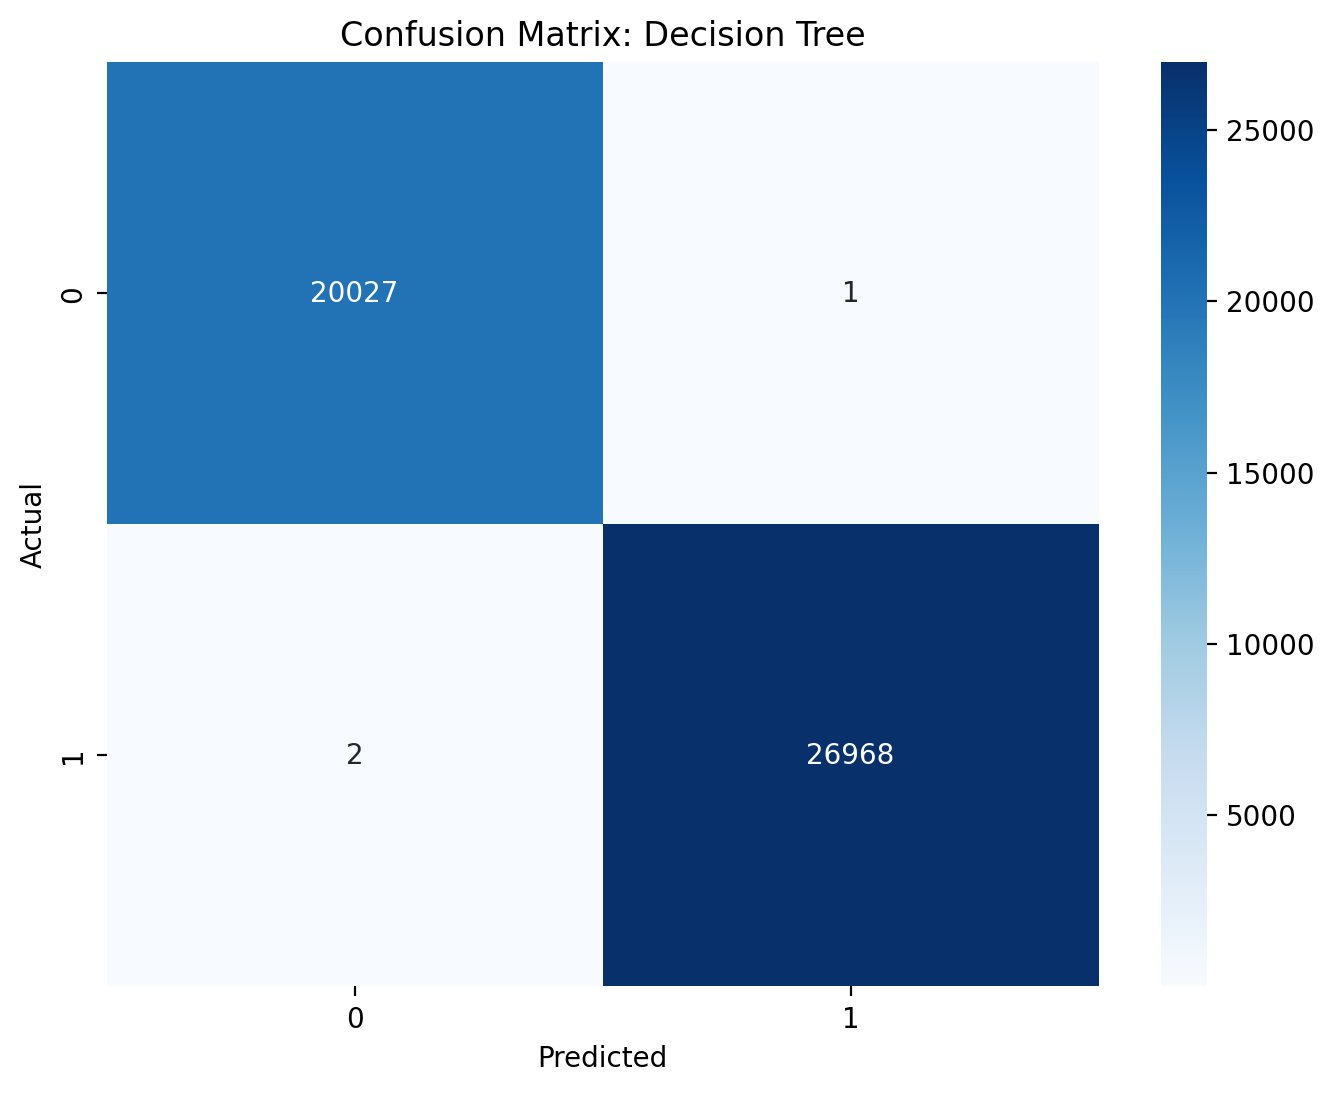

 

🔍 Model: Random Forest
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


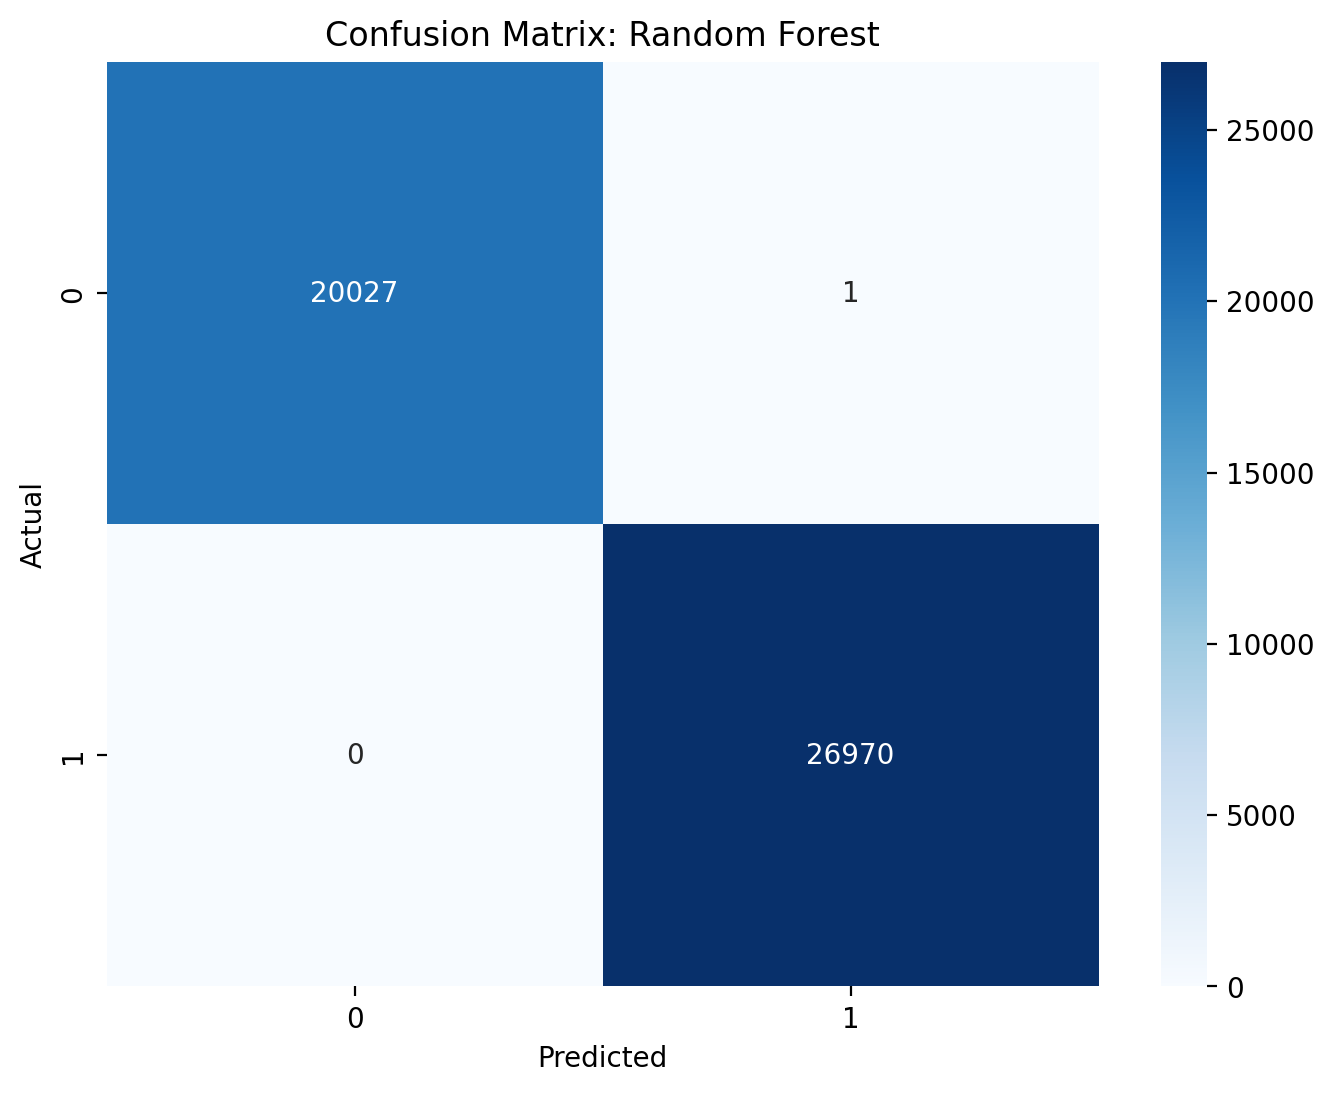

 

🔍 Model: Logistic Regression
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


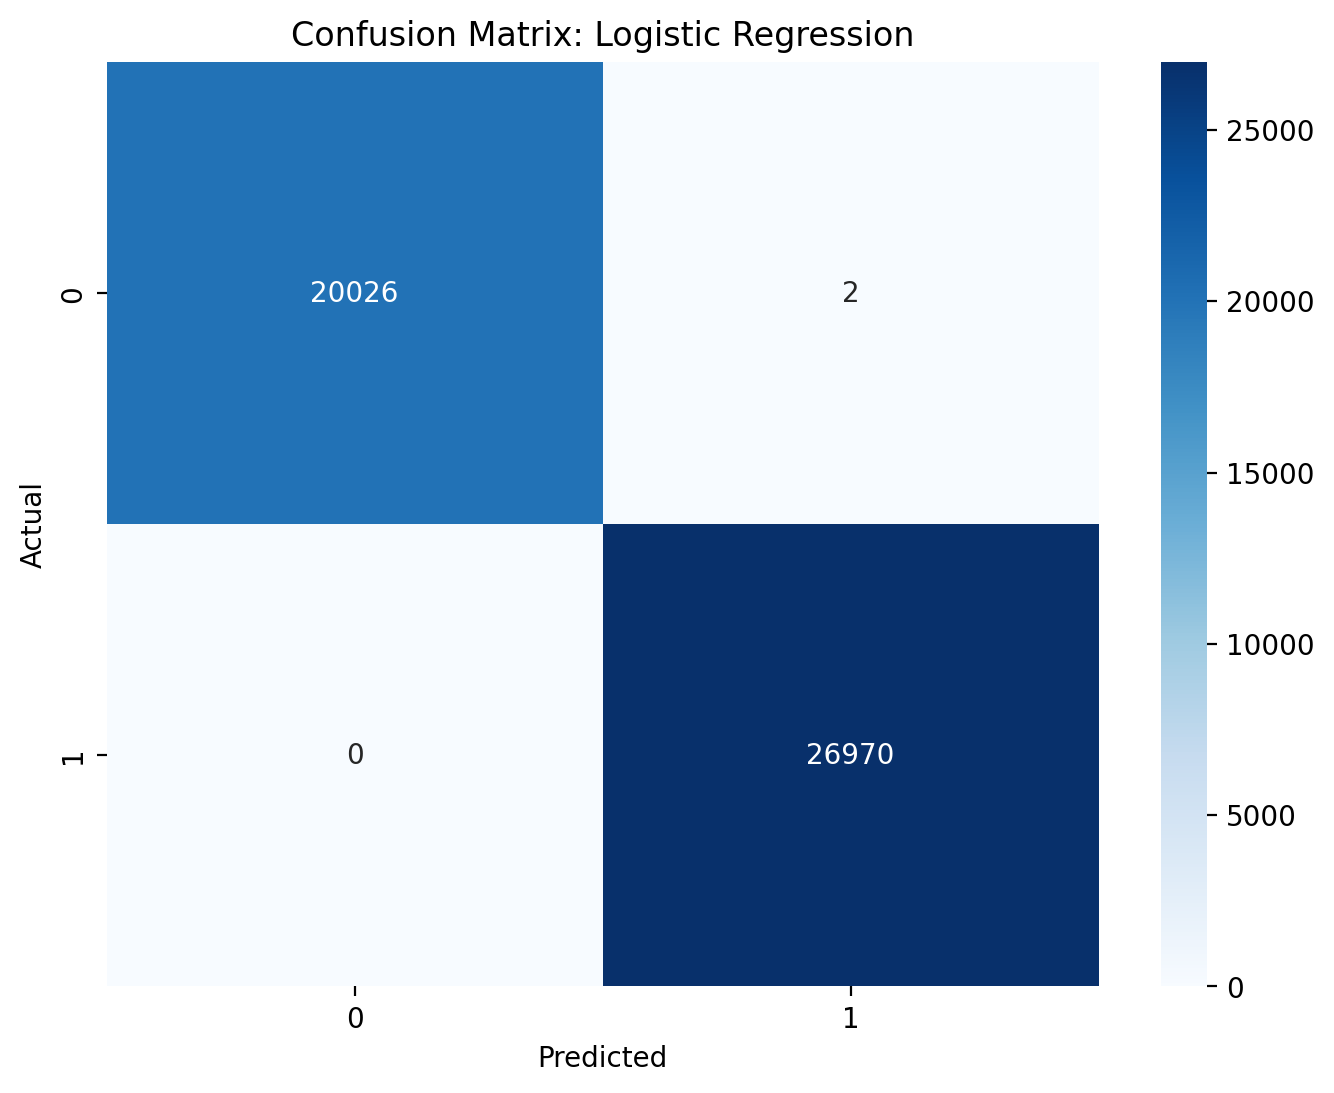

 

🔍 Model: KNN
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 0.9988

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 0.9993


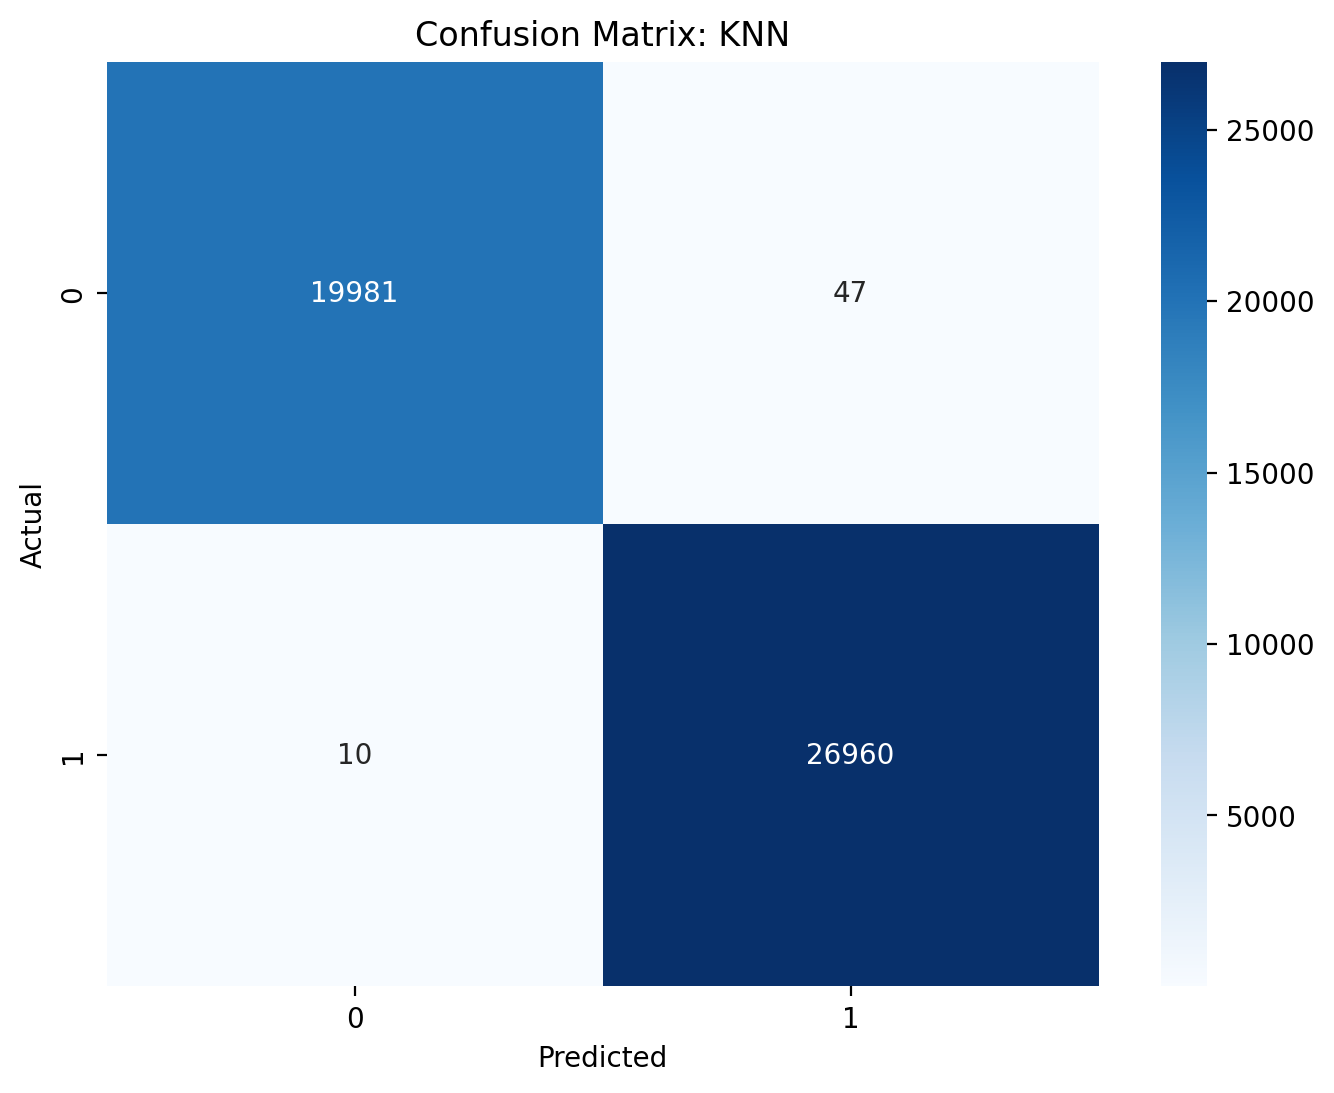

 

🔍 Model: Gradient Boosting
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


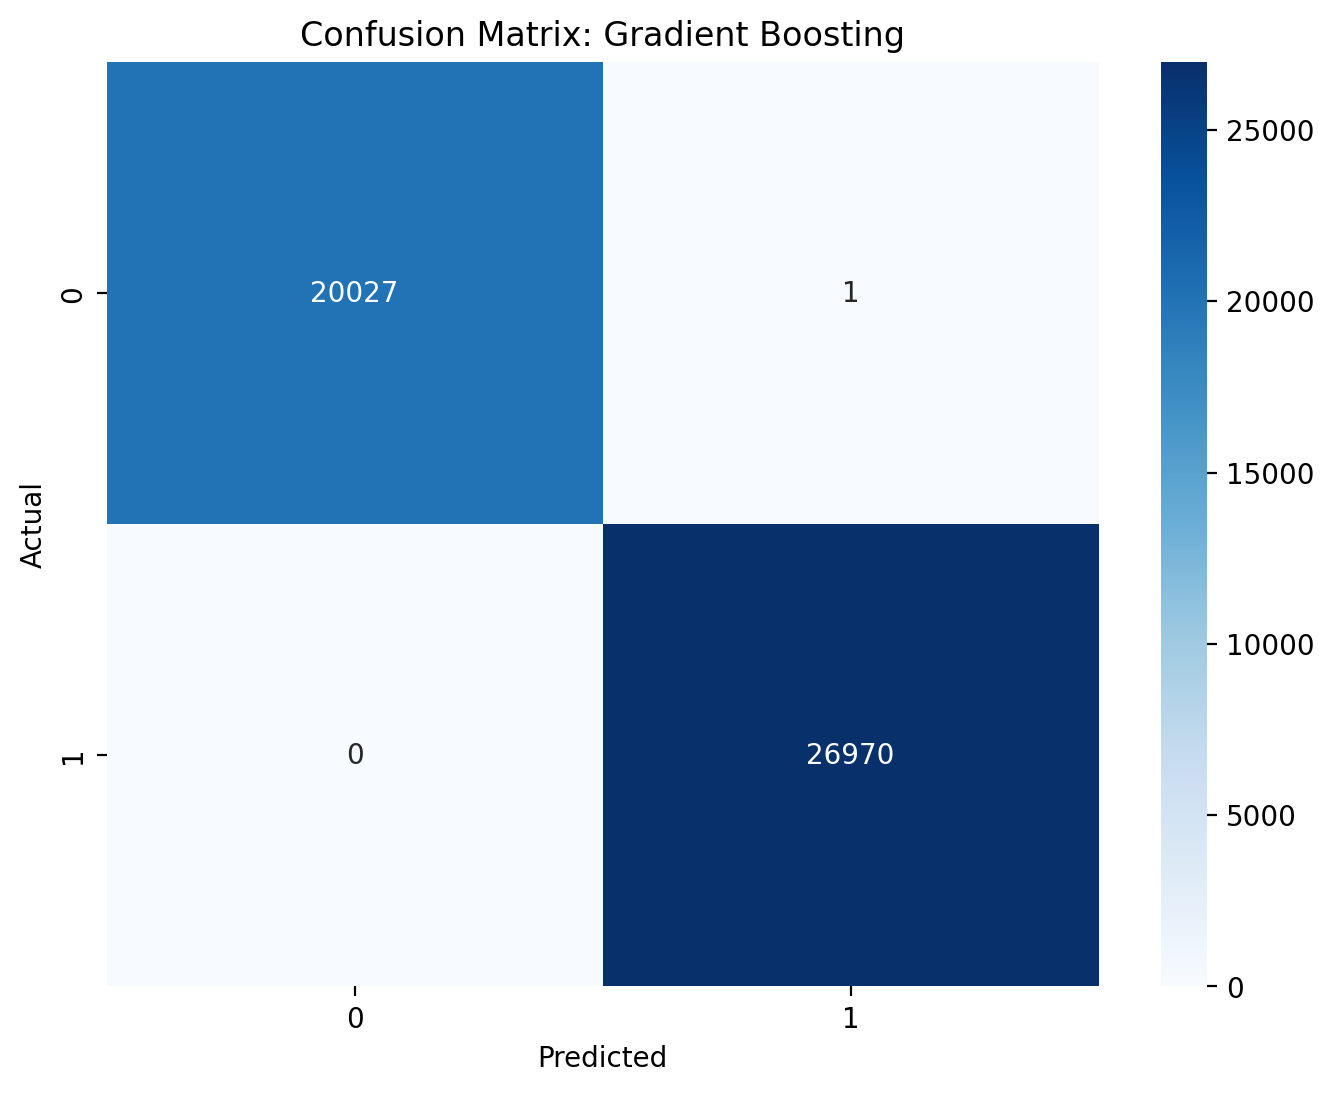

 

🔍 Model: SVM
✅ Training Accuracy: 0.9999
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


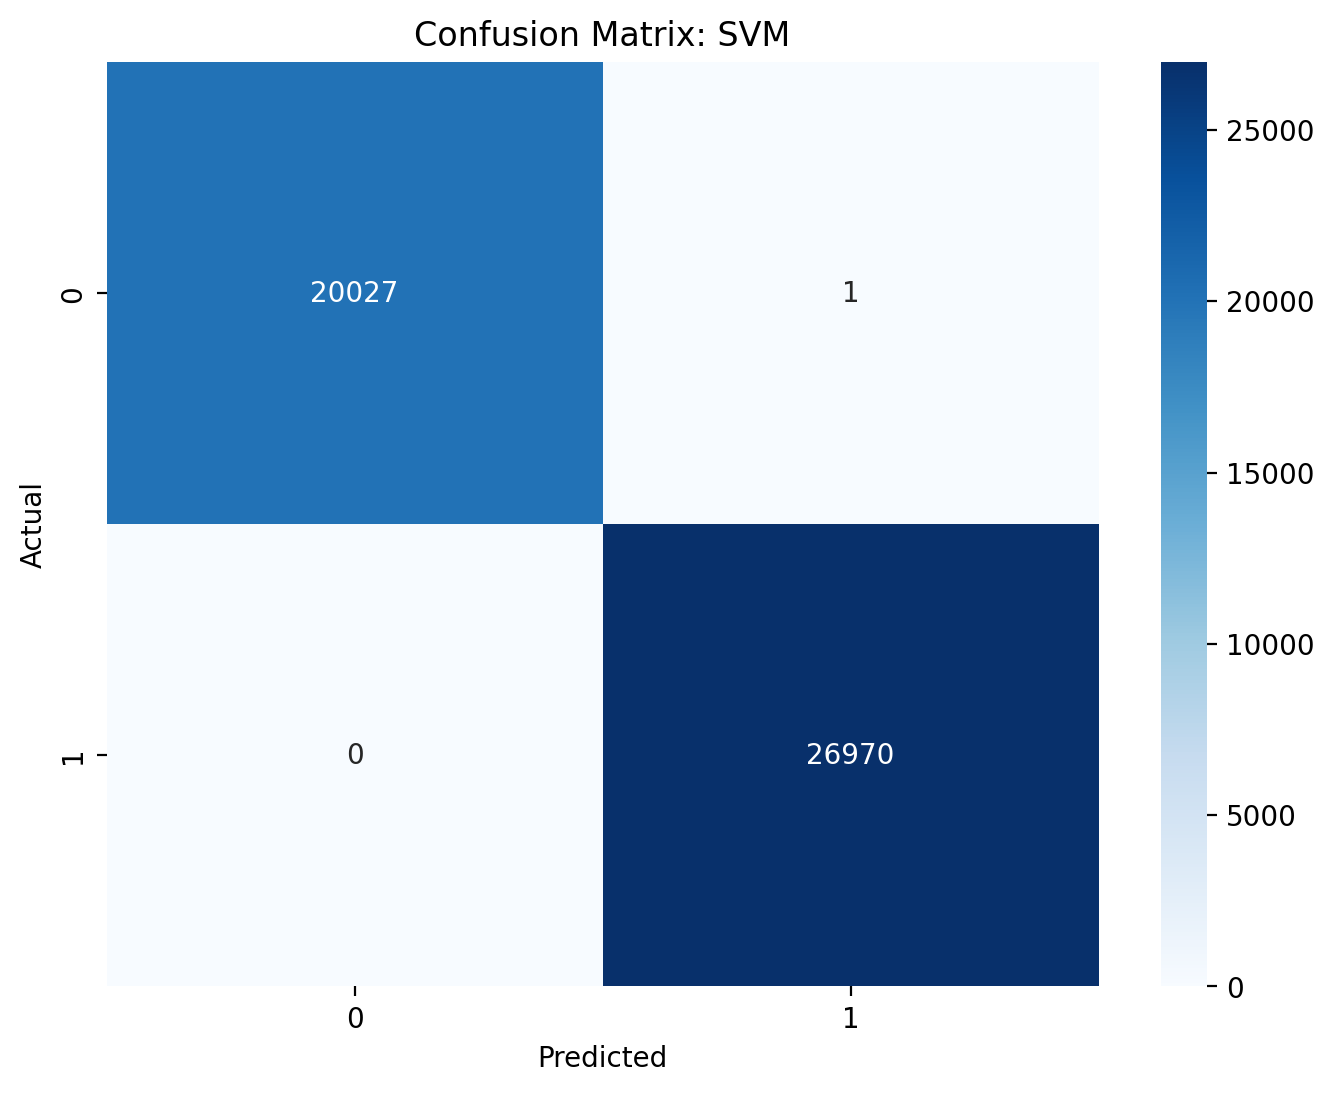

 

🔍 Model: XGBoost
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


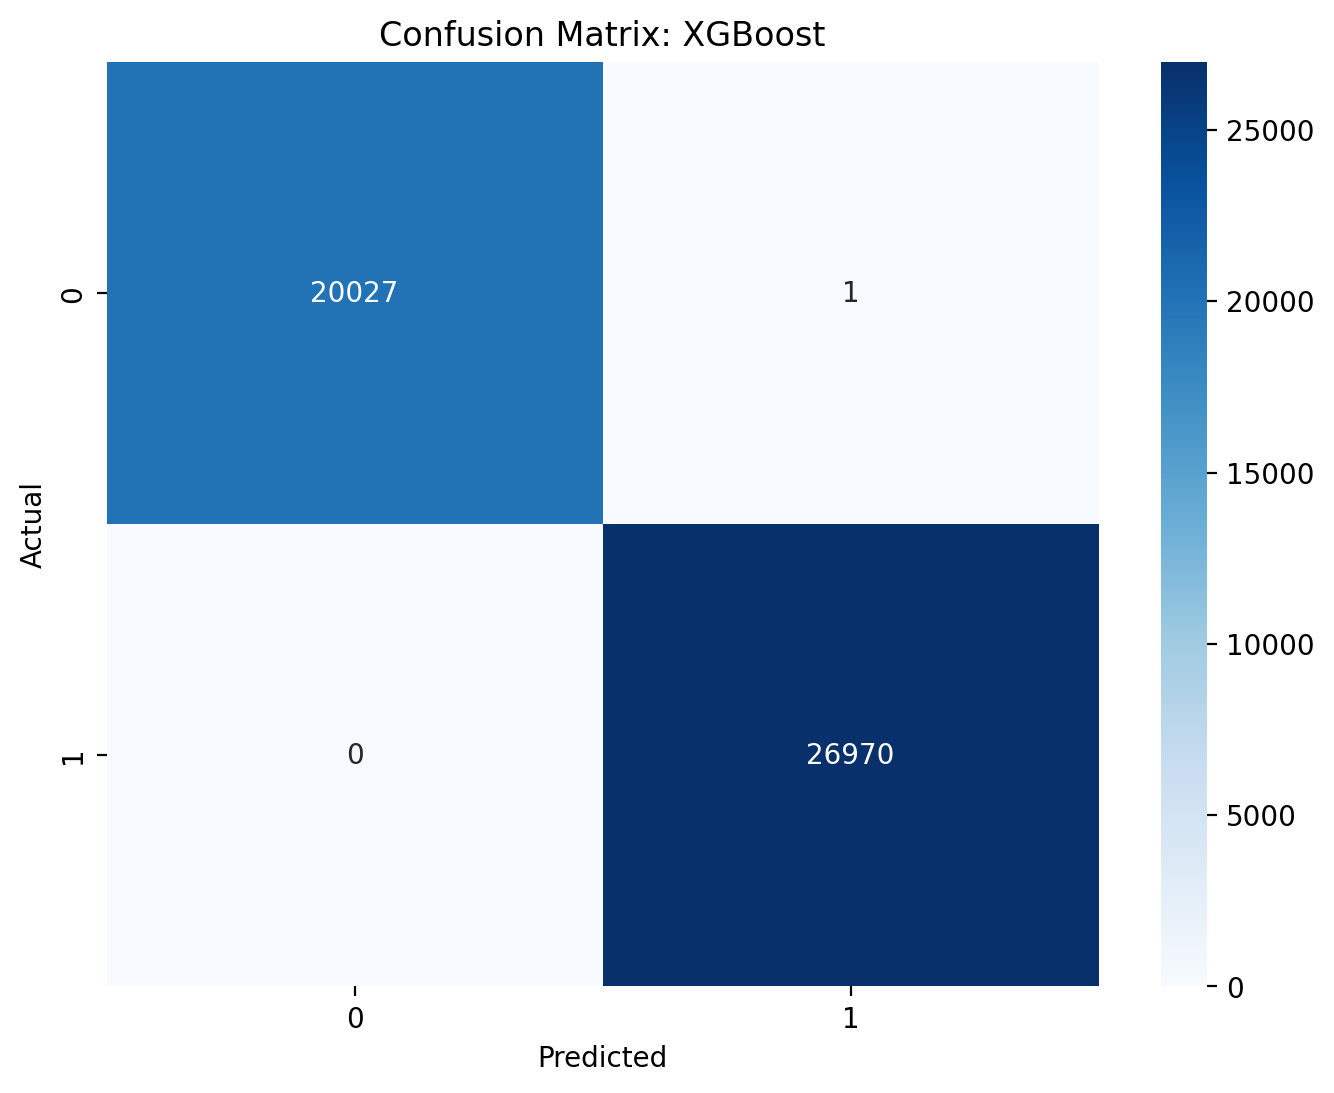

 

🔍 Model: Stacking
✅ Training Accuracy: 1.0000
✅ Test Accuracy: 1.0000

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20028
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     46998
   macro avg       1.00      1.00      1.00     46998
weighted avg       1.00      1.00      1.00     46998

📈 AUC-ROC Score: 1.0000


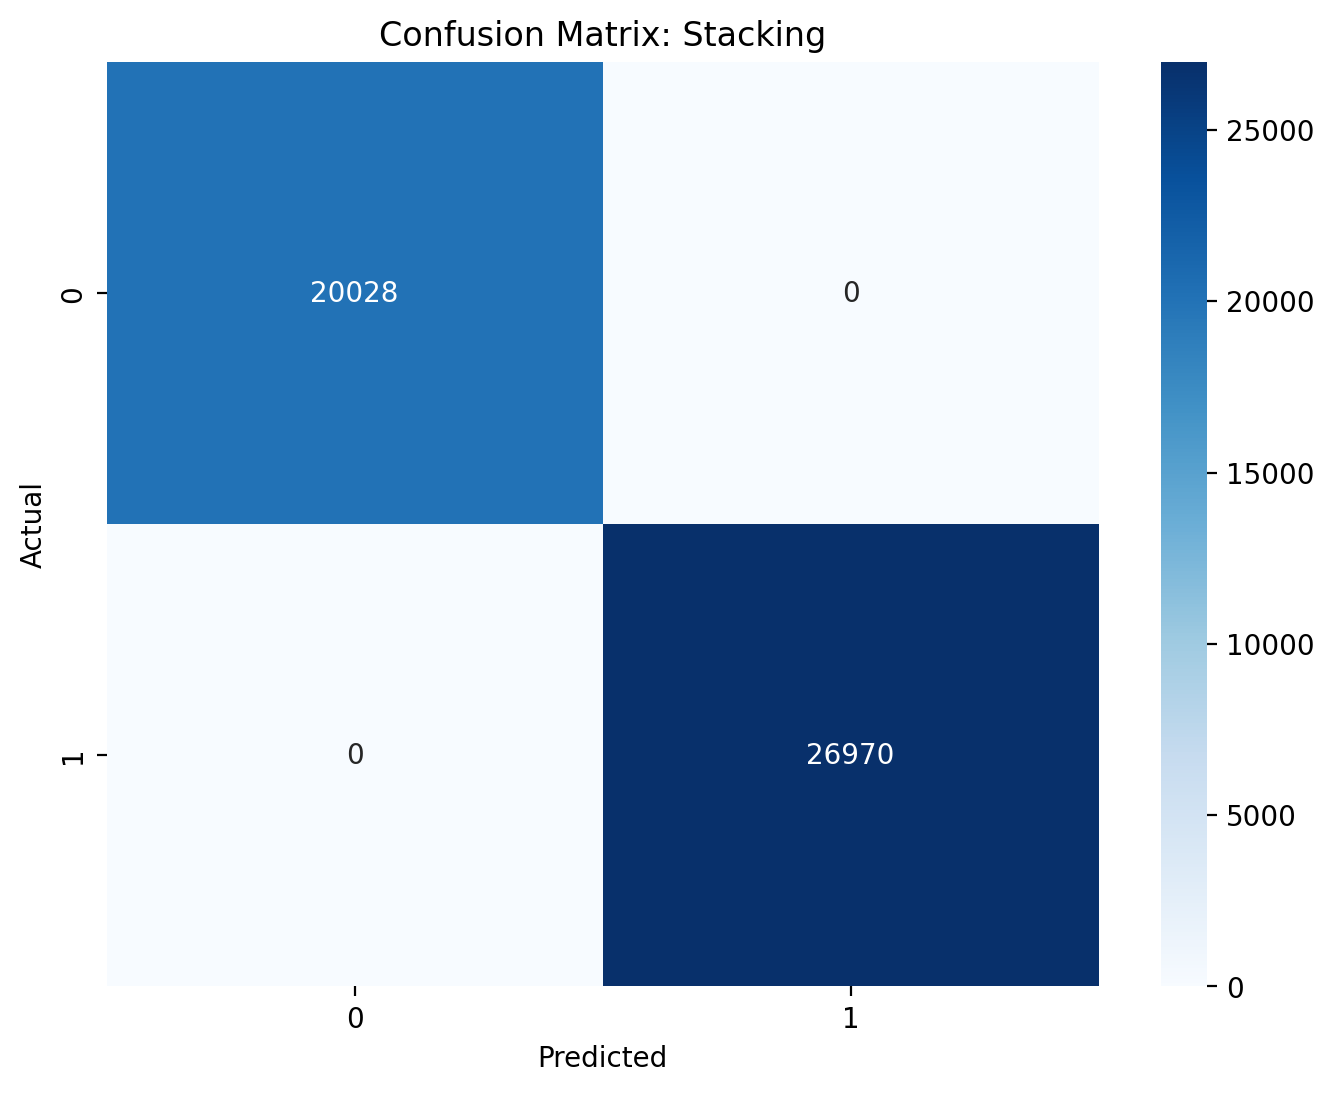

In [39]:
# Evaluate each model
for name, model in models.items():
    print(f"\n🔍 Model: {name}")

    # Predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Probabilities (for AUC)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test_selected)[:, 1]
    else:
        # For models like SVM without predict_proba
        y_test_proba = model.decision_function(X_test_selected)

    # Accuracy
    print(f"✅ Training Accuracy: {accuracy_score(y_train_resampled, y_train_pred):.4f}")
    print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # AUC-ROC
    roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f"📈 AUC-ROC Score: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6), dpi=200)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(" ")


## 6. LIME

🔎 Sample index: 18545  |  True Label: 1

🔵 Explaining model: Decision Tree


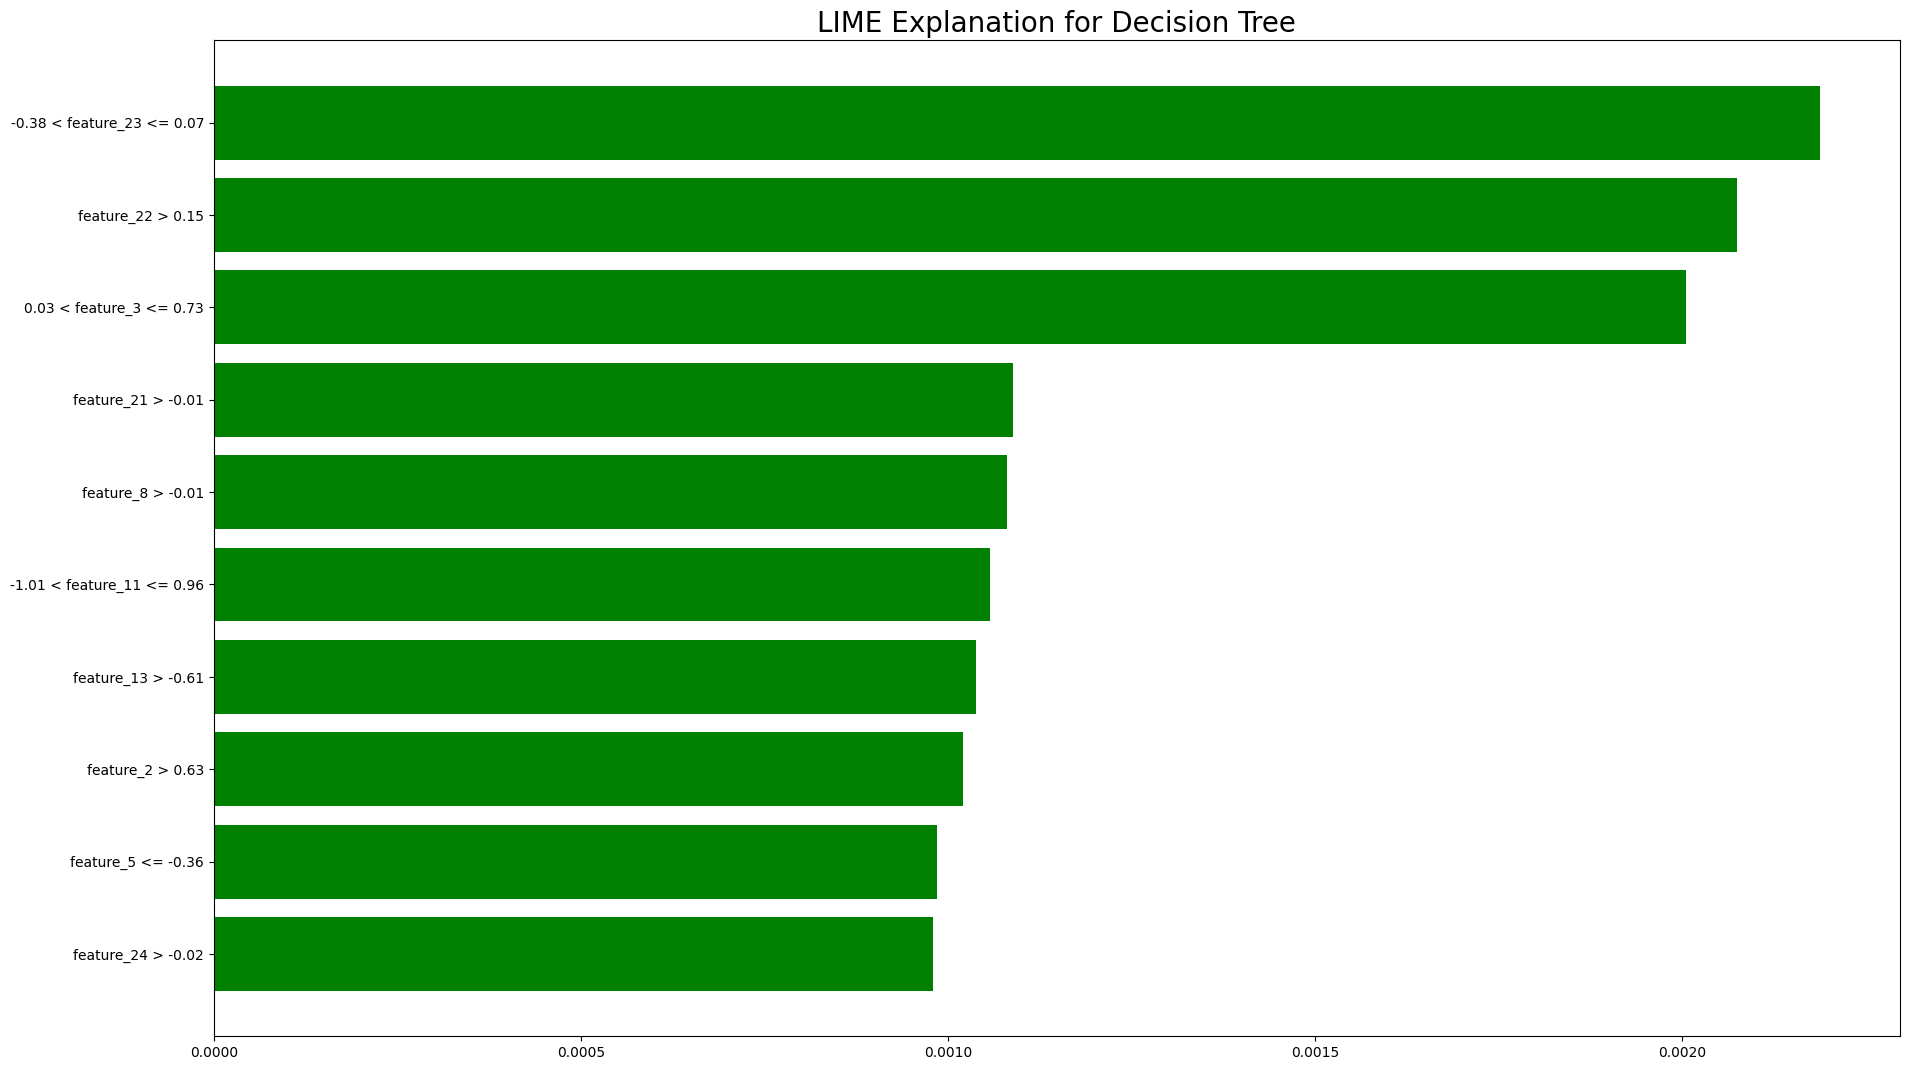


🔵 Explaining model: Random Forest


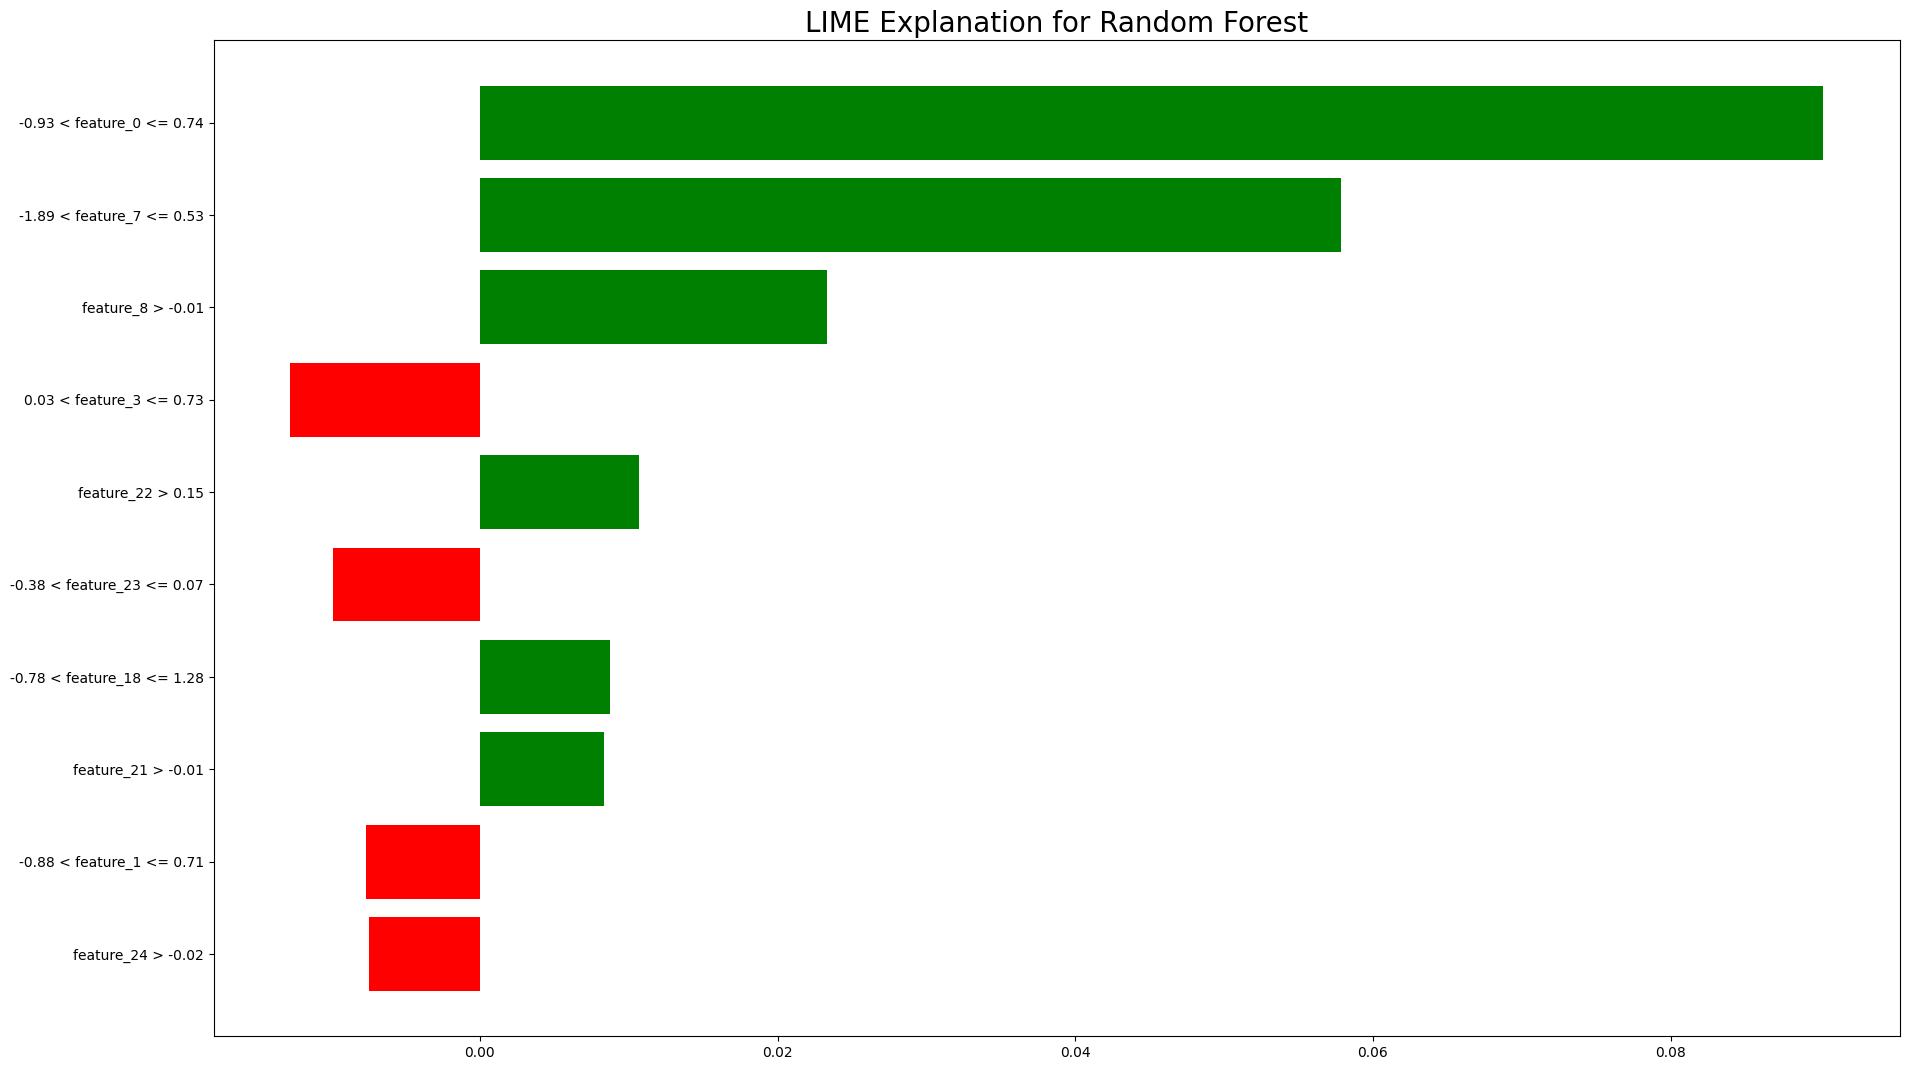


🔵 Explaining model: Logistic Regression


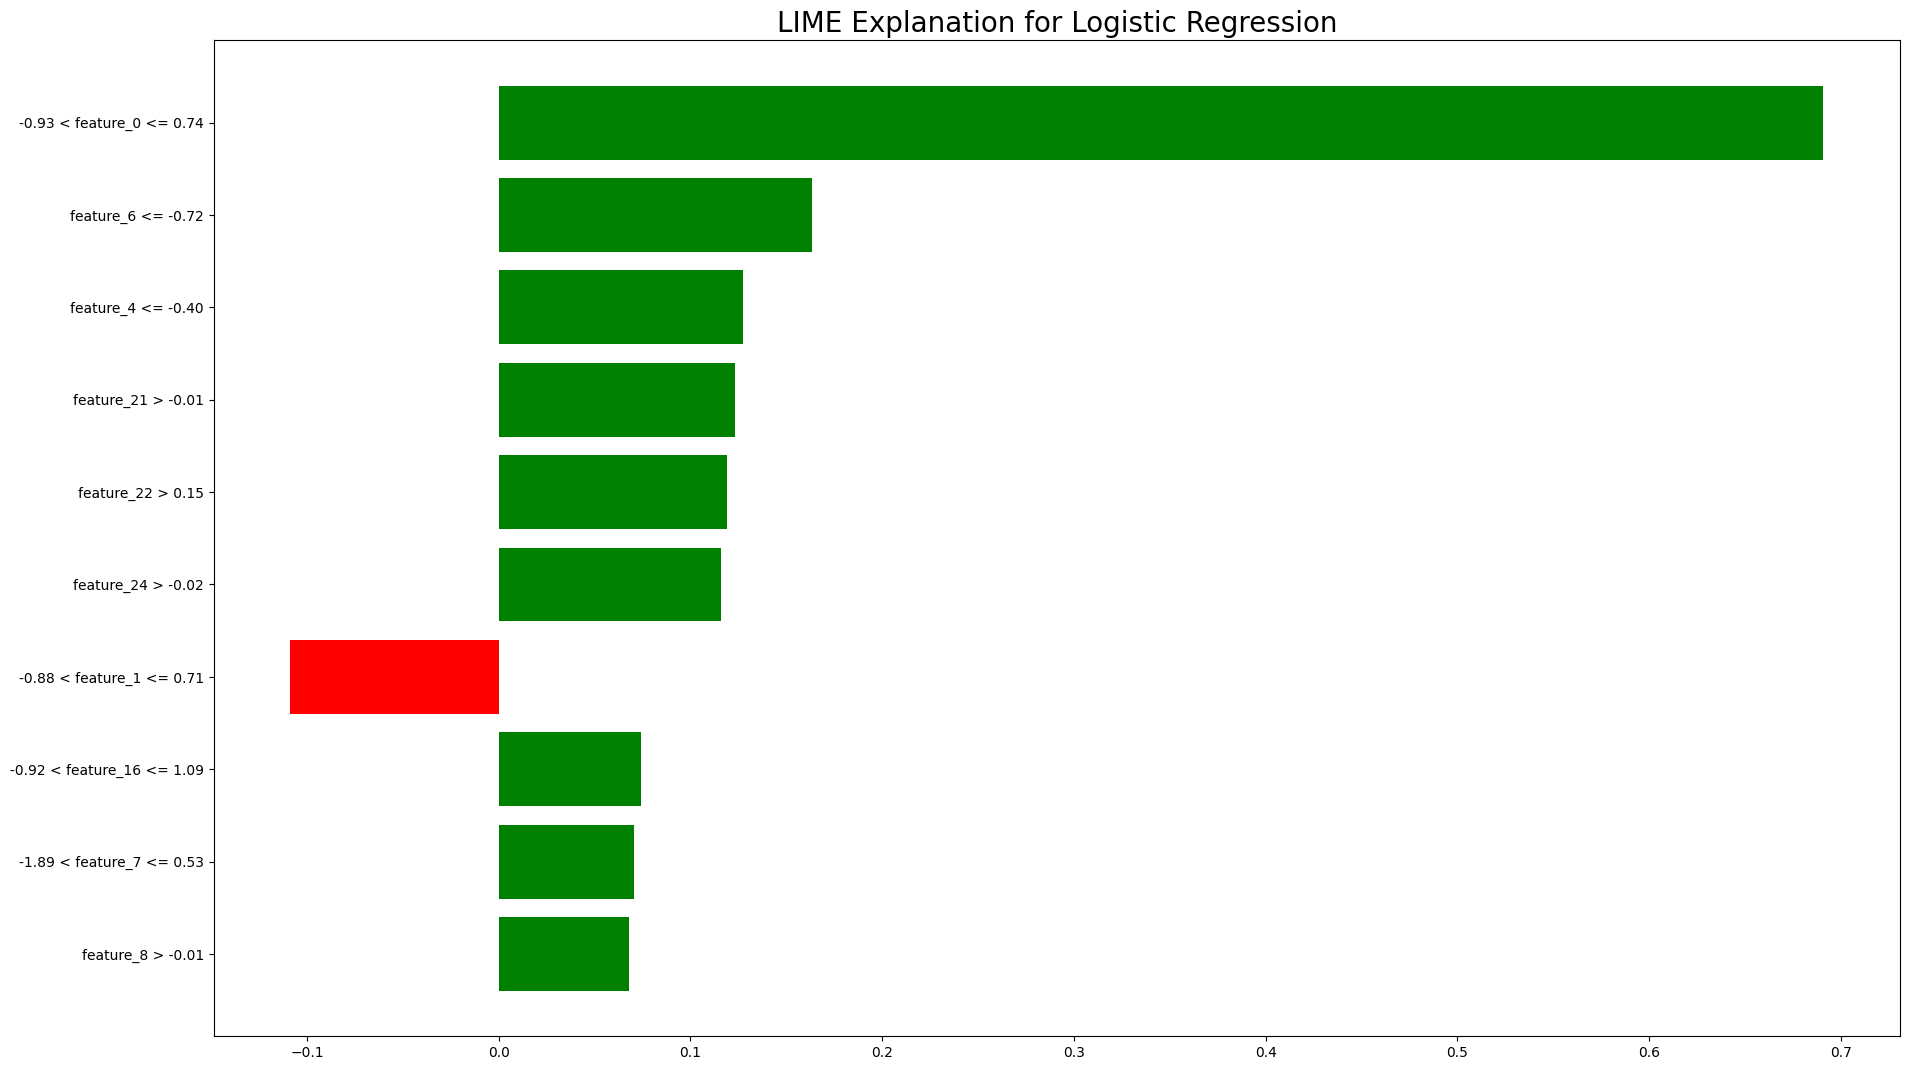


🔵 Explaining model: KNN


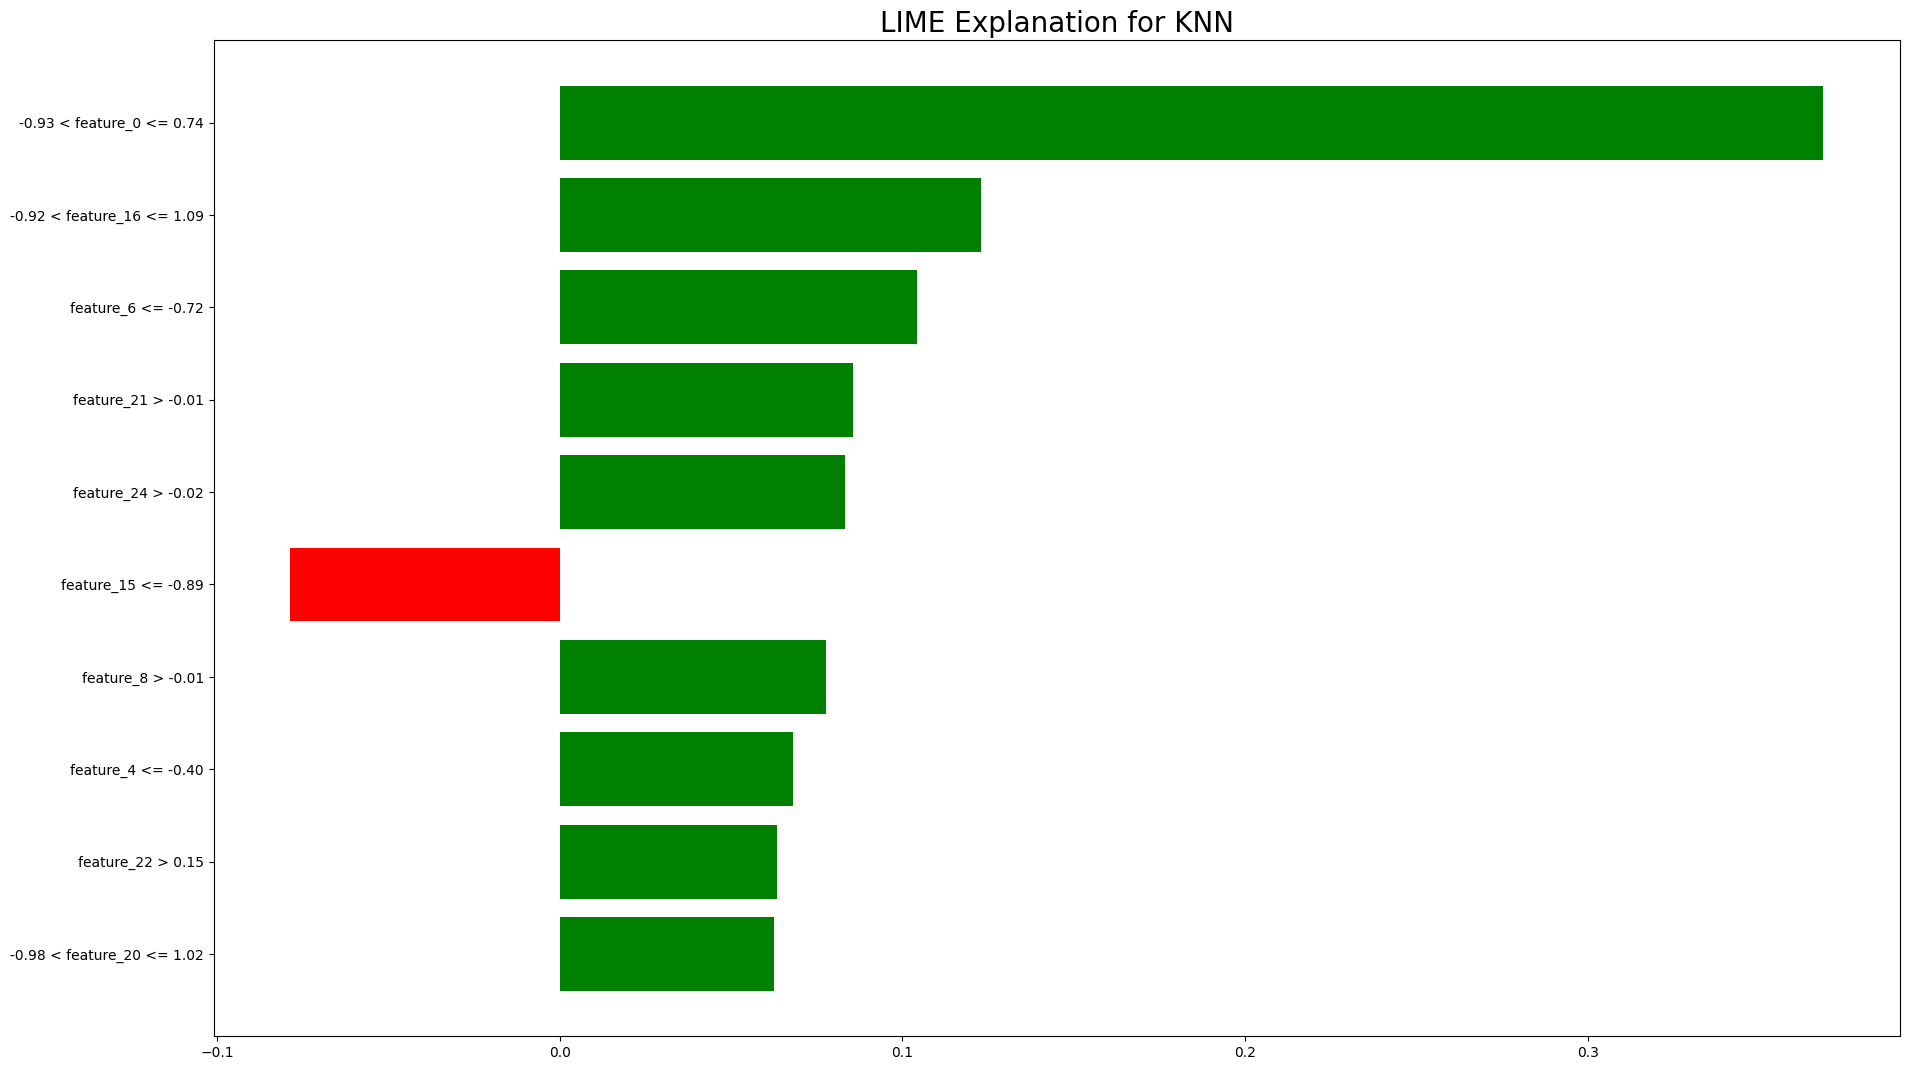


🔵 Explaining model: Gradient Boosting


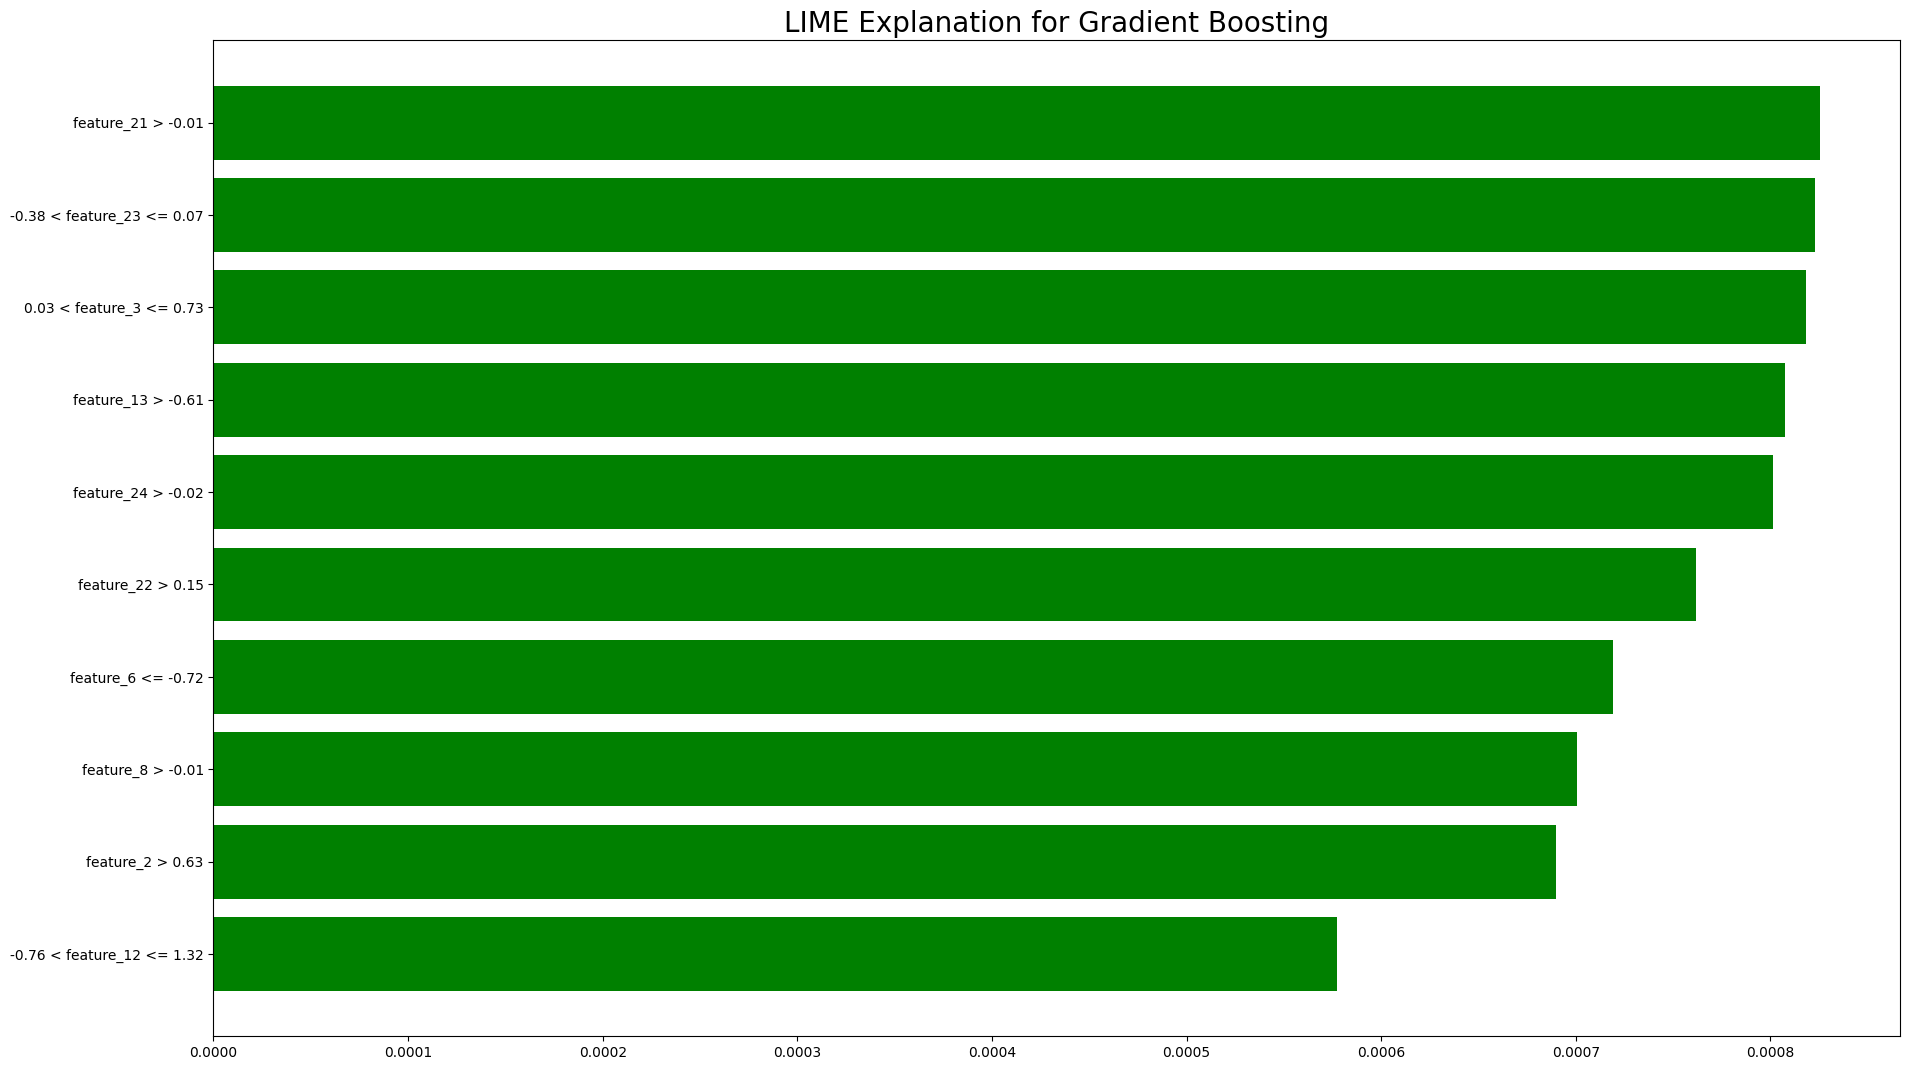


🔵 Explaining model: SVM


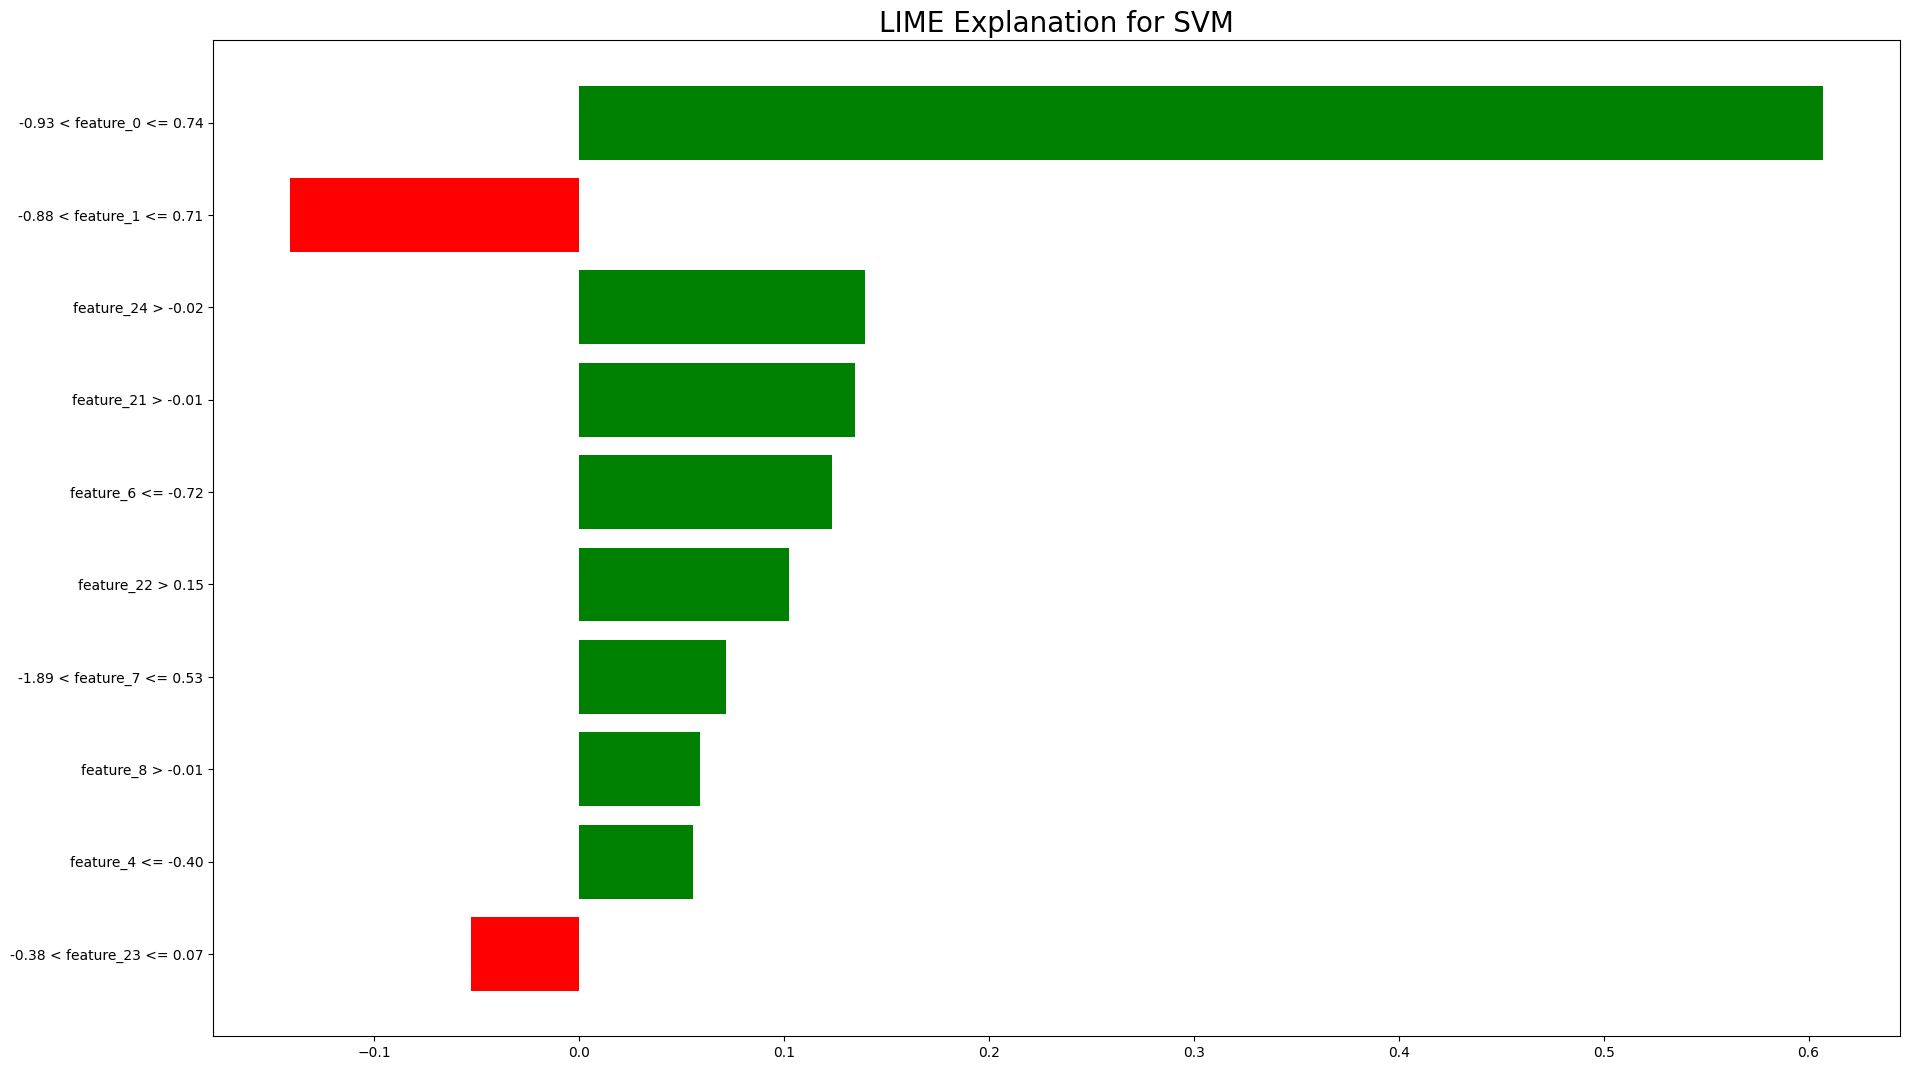


🔵 Explaining model: XGBoost


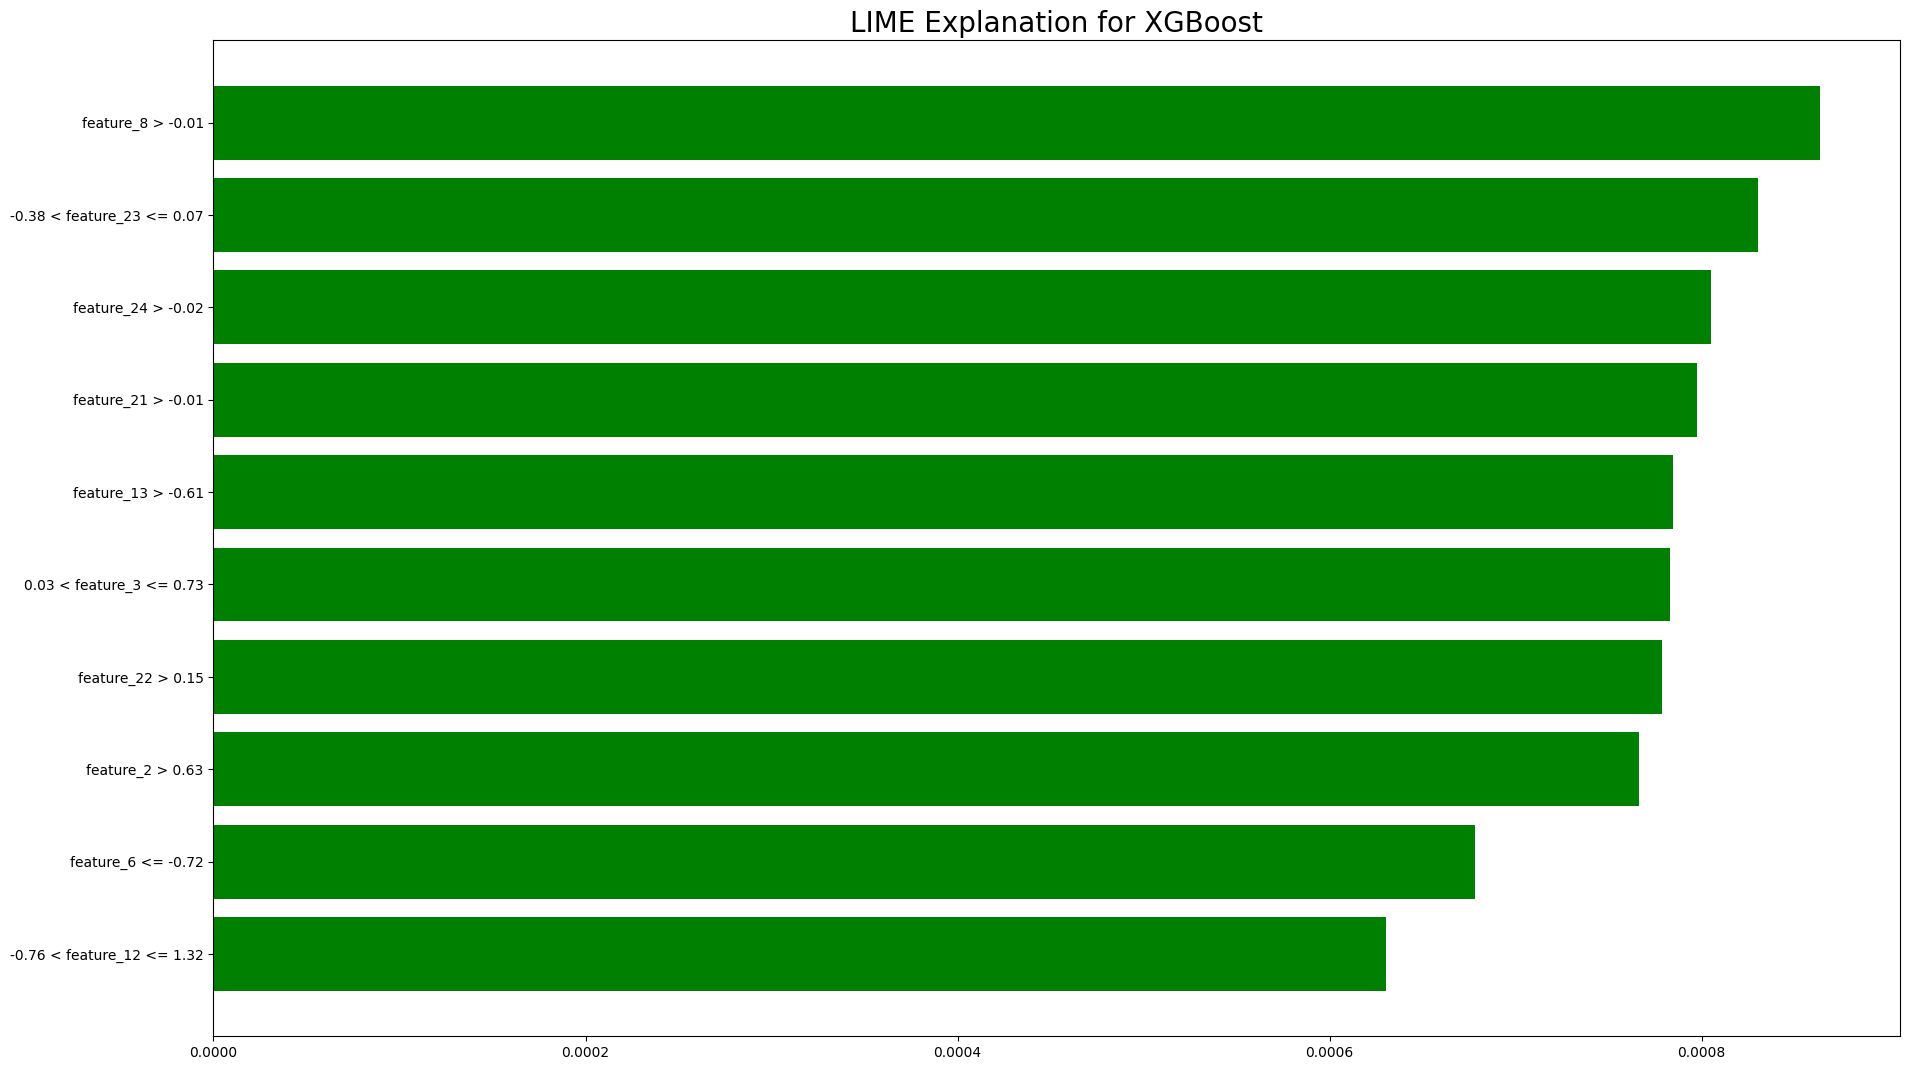


🔵 Explaining model: Stacking


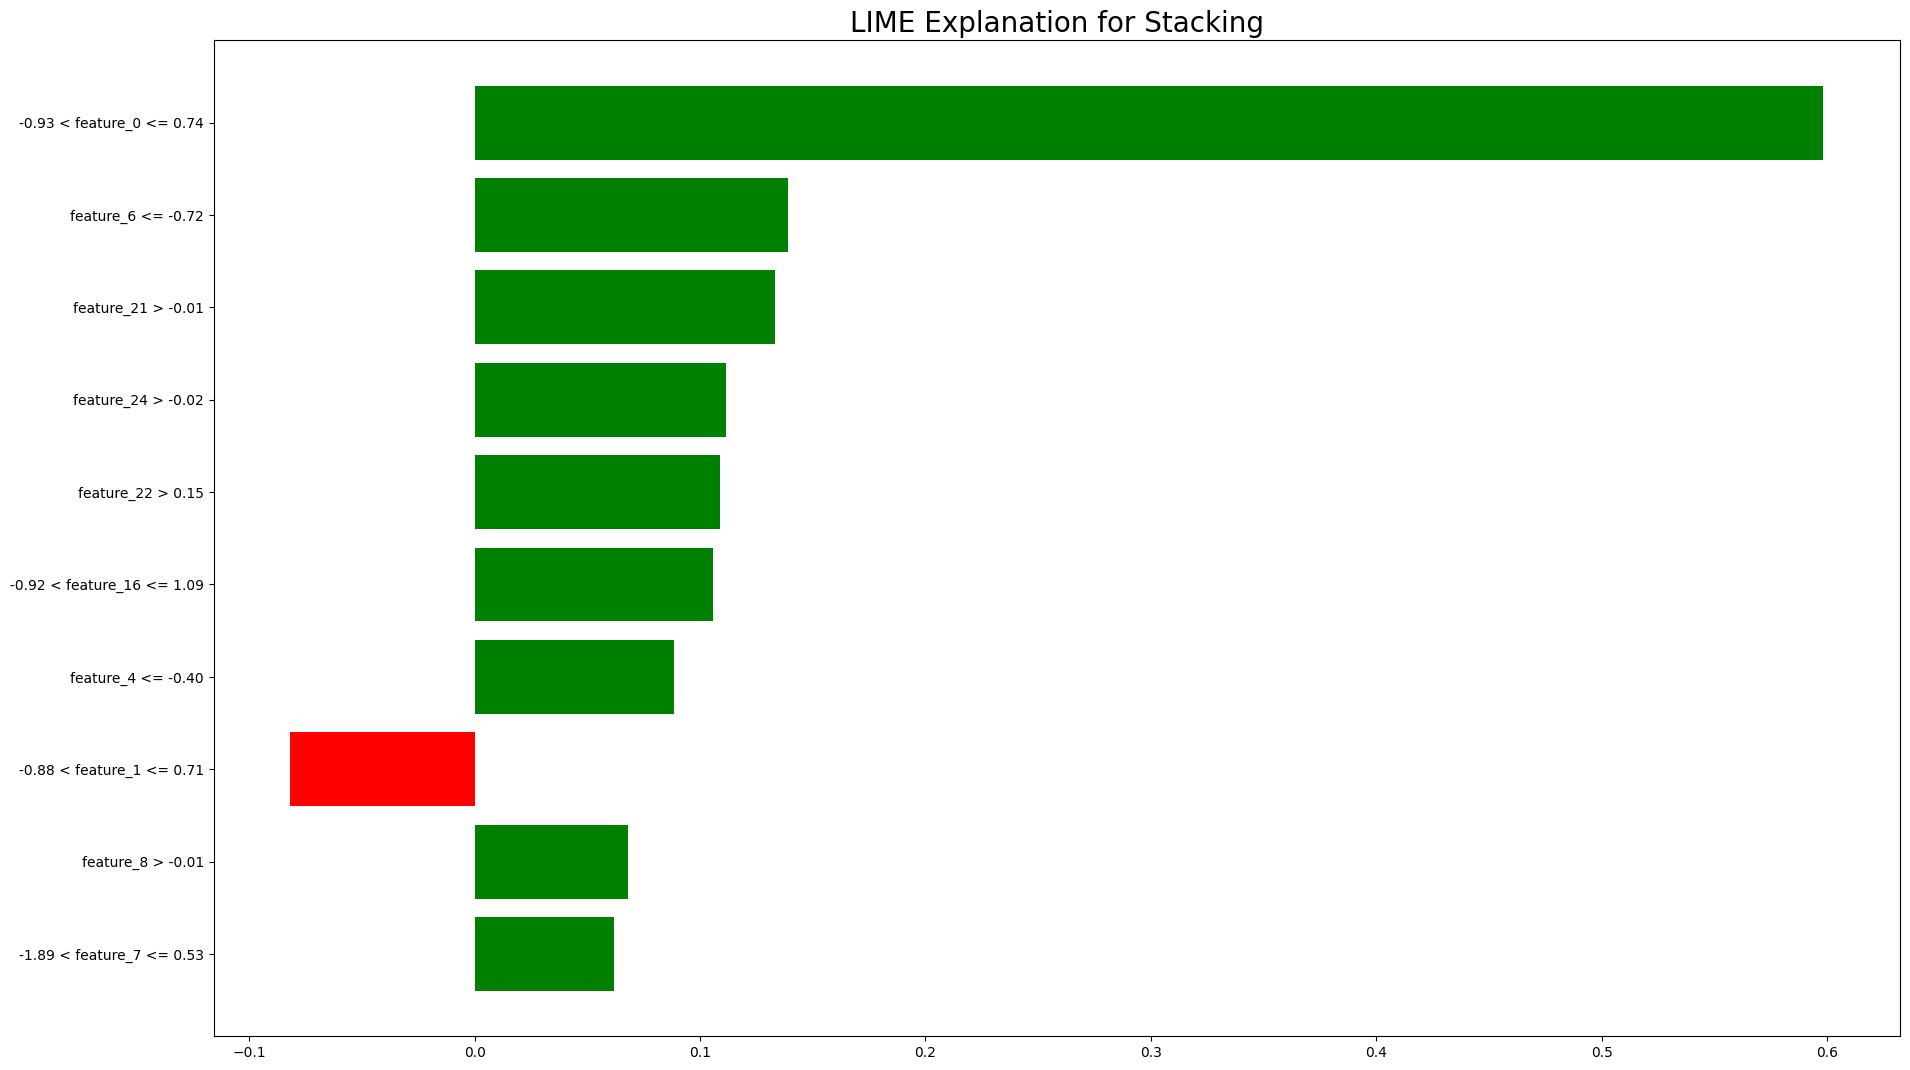

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML

# Make sure X_train_selected and X_test_selected are DataFrames
X_train_selected = pd.DataFrame(X_train_selected)
X_test_selected = pd.DataFrame(X_test_selected)

# Assign feature names manually if needed
X_train_selected.columns = [f"feature_{i}" for i in range(X_train_selected.shape[1])]
X_test_selected.columns = X_train_selected.columns

# 1. Initialize LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train_selected.values,
    feature_names=X_train_selected.columns.tolist(),
    class_names=['Non-Phishing', 'Phishing'],
    mode='classification'
)

# 2. Pick a random test sample
sample_idx = np.random.randint(0, X_test_selected.shape[0])
sample = X_test_selected.iloc[sample_idx]
true_label = y_test.iloc[sample_idx]

print(f"🔎 Sample index: {sample_idx}  |  True Label: {true_label}")

# 3. LIME Explain for each model
for model_name, model in models.items():
    print(f"\n🔵 Explaining model: {model_name}")

    exp = explainer.explain_instance(
        data_row=sample.values,
        predict_fn=model.predict_proba
    )

    # Plot with 1080p resolution
    fig = exp.as_pyplot_figure()
    fig.set_size_inches(19.2, 10.8)
    plt.title(f"LIME Explanation for {model_name}", fontsize=20)
    plt.tight_layout()
    plt.show()